In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import wntr
from pathlib import Path
from infrarisk.src.network_sim_models.interdependencies import *
from infrarisk.src.network_recovery import *

import math
import copy

In [2]:
network_dir= 'micropolis'

MAIN_DIR = Path('../..')
water_file = MAIN_DIR/'infrarisk/data/networks/{0}/water/water.inp'.format(network_dir)

step_size = 60
try:
    wn_original = wntr.network.WaterNetworkModel(water_file)
    wn_original.options.time.duration = 3600
    wn_original.options.time.report_timestep = 3600
    wn_original.options.time.hydraulic_timestep = 60
    wn_original.options.hydraulic.demand_model = 'DDA'
    
    print("Water network successfully loaded.")
except FileNotFoundError:
    print("Error: The water network file does not exist. No such file or directory: ", water_file)

Water network successfully loaded.


C:\Users\srijith\anaconda3\envs\redcar\lib\site-packages\wntr\epanet\io.py:2173: UserWarning: Not all curves were used in "..\..\infrarisk\data\networks\micropolis\water\water.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


In [9]:
wn = copy.deepcopy(wn_original)
wn.options.hydraulic.required_pressure = 30
wn.options.hydraulic.minimum_pressure = 0
wn.options.hydraulic.threshold_pressure = 20

In [5]:
import infrarisk.src.network_sim_models.water.water_network_model as water

In [16]:
water_dir = MAIN_DIR/'infrarisk/data/networks/{0}/water'.format(network_dir)
#water.generate_base_supply(wn, dir = water_dir)

In [17]:
#components = ['W_PSC282', 'W_PMA535', 'W_PSC1054', 'W_PMA1043']
components =  ['W_PMA1050', 'W_PMA1118', 'W_PMA609', 'W_PMA608', 'W_PMA937']
start_time = 6000
end_time = 22000

for component in components:
    wn = wntr.morph.split_pipe(wn,component,f"{component}_B",f"{component}_leak_node",)

    leak_node = wn.get_node(f"{component}_leak_node")
    leak_node.remove_leak(wn)
    leak_node.add_leak(wn,area=0.75*(math.pi*(wn.get_link(f"{component}_B").diameter)** 2)/4,
        start_time=start_time,
        end_time=end_time,
    )

    link_close_event(wn, component, end_time, "repairing")
    link_open_event(wn, component, end_time + 20000, "repairing")

In [10]:
base_supply_df = pd.DataFrame(columns=["time", "base_supply"])

while wn.options.time.duration <=  24*3600:
    #print("Simulation time: ", wn.options.time.duration,"; Hydraulic time step: ", wn.options.time.hydraulic_timestep, "; Report time step: ", wn.options.time.report_timestep)
    wn_sim = wntr.sim.WNTRSimulator(wn)
    wn_results = wn_sim.run_sim(convergence_error=True, solver_options={"MAXITER": 10000})
        
    #print('failed pipe flowrate: ', wn_results.link['flowrate'][components].values)
    #print('total leak demand: ', wn_results.node['leak_demand'][[f'{component}_leak_node' for component in components]].values)
    # print('tank head: ', wn_results.node['head']['W_T1'].values)
    # print('total pump flow rate: ', wn_results.link['flowrate'][wn.pump_name_list].values)
    
    sim_time = wn.options.time.duration
    
    base_demands_at_t = []
    node_demand = wn_results.node["demand"].iloc[-1]
    node_pressure = wn_results.node["pressure"].iloc[-1]

    water_supplied_at_t = []
    
    for junc in wn.junction_name_list:
            if (
                node_pressure[junc]
                > wn.options.hydraulic.threshold_pressure
            ):
                water_supplied_at_t.append(node_demand[junc])
            elif (
                node_pressure[junc]
                < wn.options.hydraulic.threshold_pressure) and (node_pressure[junc] >= 0
            ):
                water_supplied_at_t.append(
                    node_demand[junc]
                    * math.sqrt(
                        node_pressure[junc]
                        / wn.options.hydraulic.threshold_pressure
                    )
                )
    base_supply_df = base_supply_df.append({"time": int(wn.options.time.duration), 
                                            "base_supply": sum(water_supplied_at_t)}, 
                                            ignore_index=True)    
    for junc in wn.junction_name_list:
        base_demand = wn.get_node(junc).base_demand

        if base_demand != 0:
            pattern = (
                wn.get_node(junc)
                .demand_timeseries_list[0]
                .pattern.multipliers
            )
            pattern_size = len(pattern)
            pattern_interval = 24 / pattern_size
            pattern_index = math.floor(
                (((sim_time) / 3600) % 24) / pattern_interval
            )

            multiplier = pattern[pattern_index]
            base_demands_at_t.append(multiplier * base_demand)

    print("Time: ",wn.options.time.duration, "Supply: ", sum(water_supplied_at_t), "Base demand: ", sum(base_demands_at_t))
    
    #print('***************')
    wn.options.time.duration += 3600
    wn.options.time.report_timestep += 3600
    


C:\Users\srijith\anaconda3\envs\redcar\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Time:  3600.0 Supply:  0.0360637615782266 Base demand:  0.0360637615782266
Time:  7200.0 Supply:  0.03755396575620661 Base demand:  0.03755396575620661
Time:  10800.0 Supply:  0.04200915624216557 Base demand:  0.04200915624216557
Time:  14400.0 Supply:  0.05251061062948877 Base demand:  0.05251061062948877


KeyboardInterrupt: 

In [9]:
base_supply_df.time = base_supply_df.time.astype(int)
base_supply_df

,time,base_supply
0,3600,0.036064
1,7200,0.026071


In [ ]:
t = 86400
node_results = wn_results.node['demand'].iloc[-1]

water_supplied = sum([node_results[junc] for junc in wn.junction_name_list])

base_demands_at_t = []

for junc in wn.junction_name_list:
    base_demand = wn.get_node(junc).base_demand
    
    if base_demand != 0:
        demand = node_results[junc]
        pattern = wn.get_node(junc).demand_timeseries_list[0].pattern.multipliers
        #print(pattern)
        pattern_size = len(pattern)
        pattern_interval = 24/pattern_size
        
        pattern_index = math.ceil(((t/3600)%86400) / pattern_interval)
        multiplier = pattern[pattern_index-1]
        base_demands_at_t.append(multiplier*base_demand)
        

water_resmetric = water_supplied/sum(base_demands_at_t)
print(water_resmetric)

1.0


In [13]:
import numpy as np
xs = water_base_supply.time
ys = water_base_supply.base_supply

np.interp(85000, xs, ys)

0.03701963888470751

In [33]:
wn = copy.deepcopy(wn_original)
wn.options.time.duration = 3600*24
wn.options.time.report_timestep = 60
wn.options.time.hydraulic_timestep = 60
wn.options.hydraulic.demand_model = "DDA"
wn.options.hydraulic.required_pressure = 30
wn.options.hydraulic.minimum_pressure = 0

In [34]:
wn_sim = wntr.sim.WNTRSimulator(wn)
wn_results = wn_sim.run_sim(
    convergence_error=True, solver_options={"MAXITER": 10000}
)

C:\Users\srijith\anaconda3\envs\redcar\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [36]:
wn_results.node['demand']

,W_JIN0,W_JTN1,W_JIN2,W_JTN3,W_JIN4,W_JTN5,W_JIN6,W_JTN7,W_JIN8,W_JTN9,...,W_JTN1828,W_JTN1829,W_JTN1830,W_JTN1831,W_JTN1832,W_JTN1833,W_JTN1834,W_T1,W_R1,W_R2
0,0.0,0.000215,0.0,0.000296,0.0,0.000033,0.0,0.000335,0.0,0.000033,...,0.000042,0.000028,0.000014,0.000014,0.000042,0.000028,0.000042,0.032432,-0.004786,-0.06371
60,0.0,0.000215,0.0,0.000296,0.0,0.000033,0.0,0.000335,0.0,0.000033,...,0.000042,0.000028,0.000014,0.000014,0.000042,0.000028,0.000042,0.032426,-0.004780,-0.06371
120,0.0,0.000215,0.0,0.000296,0.0,0.000033,0.0,0.000335,0.0,0.000033,...,0.000042,0.000028,0.000014,0.000014,0.000042,0.000028,0.000042,0.032420,-0.004774,-0.06371
180,0.0,0.000215,0.0,0.000296,0.0,0.000033,0.0,0.000335,0.0,0.000033,...,0.000042,0.000028,0.000014,0.000014,0.000042,0.000028,0.000042,0.032414,-0.004768,-0.06371
240,0.0,0.000215,0.0,0.000296,0.0,0.000033,0.0,0.000335,0.0,0.000033,...,0.000042,0.000028,0.000014,0.000014,0.000042,0.000028,0.000042,0.032408,-0.004762,-0.06371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86160,0.0,0.000215,0.0,0.000296,0.0,0.000033,0.0,0.000335,0.0,0.000033,...,0.000042,0.000028,0.000014,0.000014,0.000042,0.000028,0.000042,0.030952,-0.005763,-0.06371
86220,0.0,0.000215,0.0,0.000296,0.0,0.000033,0.0,0.000335,0.0,0.000033,...,0.000042,0.000028,0.000014,0.000014,0.000042,0.000028,0.000042,0.030946,-0.005757,-0.06371
86280,0.0,0.000215,0.0,0.000296,0.0,0.000033,0.0,0.000335,0.0,0.000033,...,0.000042,0.000028,0.000014,0.000014,0.000042,0.000028,0.000042,0.030941,-0.005752,-0.06371
86340,0.0,0.000215,0.0,0.000296,0.0,0.000033,0.0,0.000335,0.0,0.000033,...,0.000042,0.000028,0.000014,0.000014,0.000042,0.000028,0.000042,0.030935,-0.005746,-0.06371


In [44]:
base_supply_df = wn_results.node['demand'][wn.junction_name_list]

In [46]:
base_supply_df['time'] = base_supply_df.index
base_supply_df.head()

,W_JIN0,W_JTN1,W_JIN2,W_JTN3,W_JIN4,W_JTN5,W_JIN6,W_JTN7,W_JIN8,W_JTN9,...,W_JTN1826,W_JTN1827,W_JTN1828,W_JTN1829,W_JTN1830,W_JTN1831,W_JTN1832,W_JTN1833,W_JTN1834,time
0,0.0,0.000215,0.0,0.000296,0.0,0.000033,0.0,0.000335,0.0,0.000033,...,0.000014,0.000021,0.000042,0.000028,0.000014,0.000014,0.000042,0.000028,0.000042,0
60,0.0,0.000215,0.0,0.000296,0.0,0.000033,0.0,0.000335,0.0,0.000033,...,0.000014,0.000021,0.000042,0.000028,0.000014,0.000014,0.000042,0.000028,0.000042,60
120,0.0,0.000215,0.0,0.000296,0.0,0.000033,0.0,0.000335,0.0,0.000033,...,0.000014,0.000021,0.000042,0.000028,0.000014,0.000014,0.000042,0.000028,0.000042,120
180,0.0,0.000215,0.0,0.000296,0.0,0.000033,0.0,0.000335,0.0,0.000033,...,0.000014,0.000021,0.000042,0.000028,0.000014,0.000014,0.000042,0.000028,0.000042,180
240,0.0,0.000215,0.0,0.000296,0.0,0.000033,0.0,0.000335,0.0,0.000033,...,0.000014,0.000021,0.000042,0.000028,0.000014,0.000014,0.000042,0.000028,0.000042,240


In [9]:
import infrarisk.src.network_sim_models.water.water_network_model as water

In [48]:
water_node_head_df = pd.DataFrame(columns=[node for node in wn_results.node['head'].columns],
                                  data = wn_results.node["head"].iloc[[-1]])

In [51]:
water_node_head_df

,W_JIN0,W_JTN1,W_JIN2,W_JTN3,W_JIN4,W_JTN5,W_JIN6,W_JTN7,W_JIN8,W_JTN9,...,W_JTN1833,W_JTN1834,W_PMA1050_leak_node,W_PMA1118_leak_node,W_PMA609_leak_node,W_PMA608_leak_node,W_PMA937_leak_node,W_T1,W_R1,W_R2
0,352.827093,352.826514,352.828588,352.827935,352.832323,352.832315,352.83287,352.832047,352.829133,352.829122,...,352.857672,352.857672,352.872349,352.939163,352.939888,352.911073,352.861292,352.68056,283.464,313.944
1,352.827093,352.826514,352.828588,352.827935,352.832323,352.832315,352.83287,352.832047,352.829133,352.829122,...,352.857672,352.857672,352.872349,352.939163,352.939888,352.911073,352.861292,352.68056,283.464,313.944


In [50]:
water_node_head_df = pd.concat([water_node_head_df, wn_results.node['head'].iloc[[-1]]], ignore_index=True)

In [47]:
water_node_head_df.loc[len(water_node_head_df)] =  wn_results.node['head'].iloc[[-1]]

ValueError: cannot set a row with mismatched columns

In [89]:
pump_list = wn.pump_name_list
water_pump_df = pd.DataFrame(
                columns=[pump for pump in pump_list],
                data=wn_results.link["flowrate"][pump_list].iloc[[-1]],
            )

In [87]:
wn_results.link["flowrate"][pump_list].iloc[[-1]]

,W_WP1,W_WP2,W_WP3,W_WP4,W_WP5,W_WP6,W_WP7,W_WP8
3600,0.001106,0.001106,0.001106,0.001106,0.068136,0.0,0.0,0.06371


In [86]:
water_pump_df

,W_WP1,W_WP2,W_WP3,W_WP4,W_WP5,W_WP6,W_WP7,W_WP8
3600,0.001106,0.001106,0.001106,0.001106,0.068136,0.0,0.0,0.06371


In [90]:
pd.concat([water_pump_df,wn_results.link["flowrate"][pump_list].iloc[[-1]]], ignore_index=True)

,W_WP1,W_WP2,W_WP3,W_WP4,W_WP5,W_WP6,W_WP7,W_WP8
0,0.001106,0.001106,0.001106,0.001106,0.068136,0.0,0.0,0.06371
1,0.001106,0.001106,0.001106,0.001106,0.068136,0.0,0.0,0.06371


In [10]:
from sklearn import metrics

In [3]:
folder = 'C:/Users/srijith/Dropbox/Intra-CREATE Seed Grant/Integrated Model/dreaminsg_integrated_model/infrarisk/data/networks/micropolis/scenarios/track2/'

In [4]:
strategies = ['capacity', 'centrality', 'crewdist', 'zone']

for strategy in strategies:
    df = pd.read_csv(f"{folder}/{strategy}/network_performance.csv")
    time_tracker = df.time_min
    water_consump_tracker = df.water_perf
    power_consump_tracker = df.power_perf
    
    water_auc = metrics.auc(time_tracker, water_consump_tracker)  # / max(self.time_tracker)
    power_auc = metrics.auc(time_tracker,power_consump_tracker)  # / max(self.time_tracker)

    weighed_auc = 0.5 *water_auc + 0.5 * power_auc
    print(f"Weighted AUC for {strategy}-based strategy is {weighed_auc}.\n")


<AxesSubplot:xlabel='time'>

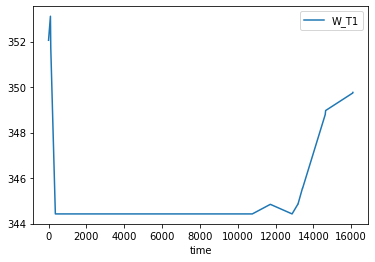

In [9]:
df[['time', 'W_T1']].plot.line(x = 'time', y = 'W_T1')
